**Computer Vision: CNN for CIFAR Dataset**

In [202]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms
import torchvision

# Functional module contains helper functions
import torch.nn.functional as F

**Create the DataLoaders**

In [203]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Resources that helped me understand CNN: <br>
https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1 <br>
https://cs231n.github.io/convolutional-networks/#layers

**Create the model**

The Conv2d layer transforms a 3-channel image, and the MaxPool2d layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

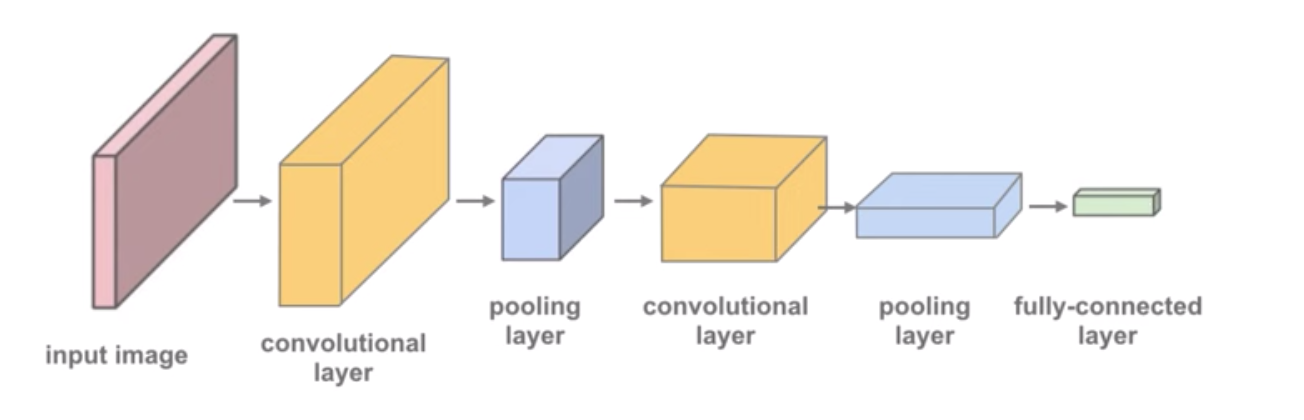

In [204]:
class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution Layer 1                       
        self.conv1 = nn.Conv2d(3, 5, kernel_size=5) 
        self.pool = nn.MaxPool2d(2, 2)
        # Convolution Layer 2             
        self.conv2 = nn.Conv2d(5, 20, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(20 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # Convolution Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Convolution Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        
        # Fully connected layer 2
        x = self.fc2(x)
        x = F.relu(x)
        
        # Fully connected layer 3
        x = self.fc3(x)
        return x

**Create the objects**

In [205]:
# The model
net = CIFARNet()

# Our loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

**Train the Model**

In [206]:
epoch_num = 2
train_loss = []

for epoch in range(epoch_num):  # loop over the dataset multiple times
    
    iter_loss = 0.0
    iterations = 0
    running_loss = 0.0
    
    net.train()                   # Put the network into training mode
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.data # Accumulate the loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            # Record the training loss
            train_loss.append(running_loss/2000)
            running_loss = 0.0

        

print('Finished Training')

[1,  2000] loss: 2.197
[1,  4000] loss: 1.888
[1,  6000] loss: 1.702
[1,  8000] loss: 1.606
[1, 10000] loss: 1.533
[1, 12000] loss: 1.487
[2,  2000] loss: 1.431
[2,  4000] loss: 1.372
[2,  6000] loss: 1.366
[2,  8000] loss: 1.355
[2, 10000] loss: 1.326
[2, 12000] loss: 1.307
Finished Training


**Calculate Accuracy of Entire Dataset**

In [207]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


**Calculate Accuracy of Each Class in Dataset**

In [208]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 69.1 %
Accuracy for class car   is: 72.3 %
Accuracy for class bird  is: 29.7 %
Accuracy for class cat   is: 39.3 %
Accuracy for class deer  is: 53.4 %
Accuracy for class dog   is: 29.6 %
Accuracy for class frog  is: 69.3 %
Accuracy for class horse is: 60.2 %
Accuracy for class ship  is: 72.2 %
Accuracy for class truck is: 46.8 %


**Visialize the loss**

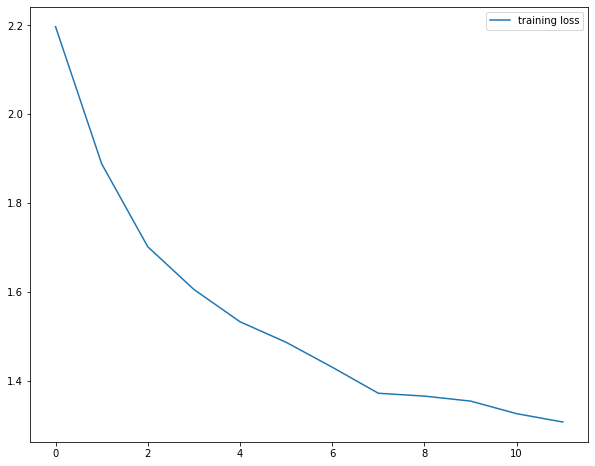

In [209]:
# Loss

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.legend()
plt.show()

**Standalone inference**

In [210]:
import numpy as np

dataiter = iter(testloader)
images, labels = dataiter.next()

ind = 1

i = images[ind].unsqueeze(0)

#i = testset[image_index][0].resize_((1, 1, 224, 224))
label = labels[ind]

net.eval()
    
output = net(i)

In [211]:
output.data

tensor([[ 7.0100,  6.6355, -2.5196, -2.4343, -2.3134, -5.4769, -6.2680, -4.4735,
          8.4795,  4.1331]])

In [212]:
_, predicted = torch.max(output.data, 1)
print("Prediction is: ", classes[predicted])

Prediction is:  ship


In [213]:
print("Actual is is: ", classes[label])

Actual is is:  ship
